<a href="https://colab.research.google.com/github/shanks266/Hateful-memes-classification/blob/main/ExplainableAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DOWNLOADING AND IMPORTING LIBRARIES

In [ ]:
!pip install \
  efficientnet_pytorch \
  git+https://github.com/openai/CLIP.git \
  scikit-learn \
  torch torchvision \
  transformers \
  pillow \
  numpy \
  pandas \
  imbalanced-learn \
  tensorflow \
  imbalanced-learn \
  streamlit

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-e7vx_00b
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-e7vx_00b
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s e

In [ ]:
from efficientnet_pytorch import EfficientNet
import clip
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import BertModel, BertTokenizer, DistilBertTokenizer, DistilBertModel
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torchvision import transforms
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [ ]:
def make_image_text_dataframe(img_path, img_text):
    """
    Creates a DataFrame with columns 'img' and 'text'.

    Parameters:
    - img_paths: list of image path strings
    - img_texts: list of text strings corresponding to each image

    Returns:
    - pandas.DataFrame with columns 'img' and 'text'
    """
    filename = os.path.basename(img_path)      # => "nonhate2.png"
    name, ext = os.path.splitext(filename) # => ("nonhate2", ".png")
    dic = {
      "id" : [name],
      "img" : [img_path],
      "text" : [img_text]
    }
    return pd.DataFrame(dic)

# Defining image path and text

In [ ]:
IMG_DIR = ["/content/nonhate2.png", "/content/hate1.png"]
IMG_TXT = ["oh no i can't run anymore", \
           "i like to hit on women with black kids because i can guarantee they’re single"]

# Resnet50 + BERT

In [ ]:
def predict_ResNet50_Bert(expl_df, model_path, device):
  class HatefulMemesDataset(Dataset):
    def __init__(self, df, img_dir, tokenizer, transform=None):
        self.df, self.img_dir = df.reset_index(drop=True), img_dir
        self.tokenizer, self.transform = tokenizer, transform

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # image
        path = os.path.join(self.img_dir, os.path.basename(row['img']))
        img  = Image.open(path).convert('RGB')
        if self.transform: img = self.transform(img)
        # text
        toks = self.tokenizer(
            row['text'], padding='max_length',
            truncation=True, max_length=128, return_tensors='pt'
        )
        return img, toks['input_ids'].squeeze(0), toks['attention_mask'].squeeze(0)

  class FeatureExtractor1(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_model = models.resnet50(pretrained=True)
        self.image_model.fc = nn.Identity()
        self.text_model  = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, img, ids, mask):
        img_feat = self.image_model(img)
        txt_feat = self.text_model(input_ids=ids, attention_mask=mask).pooler_output
        return img_feat, txt_feat

  def extract_embeddings1(extractor, loader, device):
      extractor.to(device).eval()
      imgs, txts = [], []
      for img, ids, mask in loader:
          img, ids, mask = img.to(device), ids.to(device), mask.to(device)
          i_f, t_f = extractor(img, ids, mask)
          imgs.append(i_f.cpu())
          txts.append(t_f.cpu())
      return torch.cat(imgs), torch.cat(txts)

  class WeightedMultiModalClassifier(nn.Module):
    def __init__(self, img_dim, txt_dim, hidden=256):
        super().__init__()
        self.img_dim = img_dim
        self.txt_dim = txt_dim
        self.img_fc = nn.Sequential(nn.Linear(img_dim, hidden), nn.ReLU())
        self.txt_fc = nn.Sequential(nn.Linear(txt_dim, hidden), nn.ReLU())
        self.classifier = nn.Sequential(nn.Dropout(0.4), nn.Linear(hidden, 2))
    def forward(self, x):
        img_part, txt_part = torch.split(x, [self.img_dim, self.txt_dim], dim=1)
        h_img = self.img_fc(img_part)
        h_txt = self.txt_fc(txt_part)  # text already scaled
        return self.classifier(h_img + h_txt)


  bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  data_transforms_1 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
  ])


  #expl_df = load_jsonl('/content/expl.jsonl')
  img_directory = "/content/"
  expl_ds = HatefulMemesDataset(expl_df, img_directory, bert_tokenizer, data_transforms_1)

  expl_loader = DataLoader(expl_ds, batch_size=1, shuffle=False)

  extractor1 = FeatureExtractor1()
  expl_img_feat, expl_txt_feat = extract_embeddings1(extractor1, expl_loader, device= device)

  img_dim, txt_dim = expl_img_feat.shape[1], expl_txt_feat.shape[1]

  resnet50_bert = WeightedMultiModalClassifier(img_dim, txt_dim).to(device)
  resnet50_bert.load_state_dict(torch.load(model_path, map_location=device))
  resnet50_bert.eval()


  expl_txt_feat = expl_txt_feat * 2.0
  expl_X = torch.cat([expl_img_feat, expl_txt_feat], dim=1).to(device)

  out = resnet50_bert(expl_X)

  resbert_predicted = torch.softmax(out, dim= 1).argmax(1).cpu().tolist()
  return resbert_predicted

In [ ]:
m_path = "/content/resnet50_bert_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output = []
actual = [[0], [1]]
for i_path, i_text in zip(IMG_DIR, IMG_TXT):
  #i_path = IMG_DIR
  #i_text = IMG_TXT
  dataframe = make_image_text_dataframe(i_path, i_text)

  output.append(predict_ResNet50_Bert(dataframe, m_path, device))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
output

[[0], [1]]

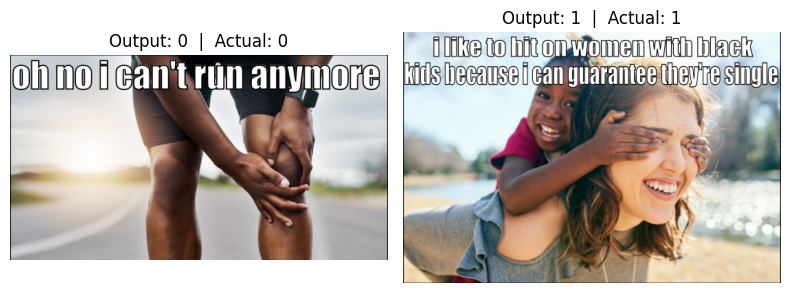

In [ ]:
import matplotlib.pyplot as plt

img_paths   = IMG_DIR

N = len(img_paths)
fig, axes = plt.subplots(1, N, figsize=(4 * N, 4))

if N == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    img = Image.open(img_paths[i])
    ax.imshow(img)

    ax.set_title(f"Output: {output[i][0]}  |  Actual: {actual[i][0]}")

    ax.axis('off')

plt.tight_layout()
plt.show()


# EfficientNet + DistilBERT

In [ ]:
def predict_EfficientNet_DistilBert(expl_df, model_path, device):
  # --- Hyperparameter Config ---
  config1 = {
      "batch_size": 1,
      "lr": 2e-5,                # Base learning rate
      "epochs": 50,              # Longer training
      "patience": 3,             # More patience for early stopping
      "weight_decay": 1e-4,
      "max_grad_norm": 1.0,
      "img_weight": 0.1,
      "txt_weight": 1.5
  }

  distil_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
  data_transforms_2 = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

  # --- Dataset ---
  class HatefulMemesDataset2(Dataset):
      def __init__(self, df, img_dir, tokenizer, transform=None):
          self.df = df.reset_index(drop=True)
          self.img_dir = img_dir
          self.tokenizer = tokenizer
          self.transform = transform

      def __len__(self):
          return len(self.df)

      def __getitem__(self, idx):
          row = self.df.iloc[idx]
          img_path = os.path.join(self.img_dir, os.path.basename(row['img']))
          image = Image.open(img_path).convert('RGB')
          if self.transform:
              image = self.transform(image)
          tokens = self.tokenizer(row['text'], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
          input_ids = tokens['input_ids'].squeeze(0)
          attention_mask = tokens['attention_mask'].squeeze(0)
          #label = torch.tensor(row['label'], dtype=torch.long)
          return image, input_ids, attention_mask


  # --- Model ---
  class MultiModalExtractor(nn.Module):
      def __init__(self):
          super().__init__()
          self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
          self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

      def forward(self, images, input_ids, attention_mask):
          img_feat = self.image_model.extract_features(images)
          # after pooling you'll have (B, C, 1, 1)
          img_feat = nn.functional.adaptive_avg_pool2d(img_feat, (1, 1))
          img_feat = img_feat.squeeze(-1).squeeze(-1)   # now (B, C)
          txt_feat = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
          return img_feat, txt_feat

  class MultiModalClassifier(nn.Module):
      def __init__(self, image_dim=1280, text_dim=768):
          super().__init__()
          self.classifier = nn.Sequential(
              nn.Linear(image_dim + text_dim, 256),
              nn.ReLU(),
              nn.Dropout(0.3),
              nn.Linear(256, 2)
          )

      def forward(self, img_feat, txt_feat):
          x = torch.cat((img_feat, txt_feat), dim=1)
          return self.classifier(x)

  # --- Feature Extraction for SMOTE ---
  @torch.no_grad()
  def extract_embeddings2(extractor, loader):
      extractor.eval()
      all_img, all_txt = [], []
      for imgs, ids, masks in loader:
          imgs, ids, masks = imgs.to(device), ids.to(device), masks.to(device)
          img_feat, txt_feat = extractor(imgs, ids, masks)
          img_feat *= 0.1  # ↓ Reduce image weight
          txt_feat *= 1.5  # ↑ Increase text weight
          all_img.append(img_feat.cpu())
          all_txt.append(txt_feat.cpu())
      return torch.cat(all_img), torch.cat(all_txt)

  img_directory = "/content/"
  expl_ds = HatefulMemesDataset2(expl_df, img_directory, distil_tokenizer, data_transforms_2)
  expl_loader = DataLoader(expl_ds, batch_size=1, shuffle=False)

  extractor2 = MultiModalExtractor().to(torch.device(device))
  eff_disbert = MultiModalClassifier().to(torch.device(device))
  img_feat, txt_feat = extract_embeddings2(extractor2, expl_loader)
  X = torch.cat([img_feat, txt_feat], dim=1).numpy()
  #y = labels.numpy()
  X_tensor = torch.tensor(X, dtype=torch.float32)
  #y_tensor = torch.tensor(y, dtype=torch.long)
  loader2 = DataLoader(TensorDataset(X_tensor), batch_size=1, shuffle=True)

  @torch.no_grad()
  def evaluate(model, extractor, loader, config):
      model.eval()
      extractor.eval()
      all_preds, all_labels, all_probs = [], [], []

      for img, ids, mask in loader:
          img, ids, mask = img.to(device), ids.to(device), mask.to(device)
          img_f, txt_f = extractor(img, ids, mask)
          img_f *= config["img_weight"]
          txt_f *= config["txt_weight"]
          out = model(img_f, txt_f)

          all_preds.append(out)
      return all_preds

  eff_disbert.load_state_dict(torch.load(model_path, map_location=device))
  eff_disbert.eval()
  output = evaluate(eff_disbert, extractor2, expl_loader, config1)
  return torch.softmax(output[0], dim= 1).argmax(1).cpu().tolist()

In [ ]:
m_path = "/content/resnet18_disbert_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output = []
actual = [[0], [1]]
for i_path, i_text in zip(IMG_DIR, IMG_TXT):
  #i_path = IMG_DIR
  #i_text = IMG_TXT
  dataframe = make_image_text_dataframe(i_path, i_text)

  output.append(predict_EfficientNet_DistilBert(dataframe, m_path, device))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 84.3MB/s]


Loaded pretrained weights for efficientnet-b0


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
output

[[0], [1]]

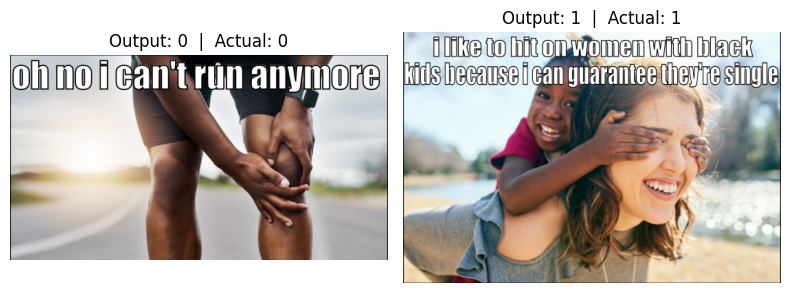

In [ ]:
import matplotlib.pyplot as plt

img_paths   = IMG_DIR

N = len(img_paths)
fig, axes = plt.subplots(1, N, figsize=(4 * N, 4))

if N == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    img = Image.open(img_paths[i])
    ax.imshow(img)

    ax.set_title(f"Output: {output[i][0]}  |  Actual: {actual[i][0]}")

    ax.axis('off')

plt.tight_layout()
plt.show()


# CLIP

In [ ]:
def predict_CLIP(expl_df, model_path, device):
  img_directory = "/content/"
  class CLIPDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df        = df.reset_index(drop=True)
        self.img_dir   = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # strip any directory and build correct path
        filename = os.path.basename(row['img'])
        img_path = os.path.join(self.img_dir, filename)

        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        text     = row['text'][:300]
        text_tok = clip.tokenize([text])[0]

        #label = torch.tensor(row['label'], dtype=torch.long)
        return image, text_tok
  # 5) Classifier on CLIP embeddings
  class EmbeddingClassifier(nn.Module):
      def __init__(self, input_dim, hidden_dim=512, dropout=0.5, num_classes=2):
          super().__init__()
          self.fc = nn.Sequential(
              nn.Linear(input_dim, hidden_dim),
              nn.ReLU(),
              nn.Dropout(dropout),
              nn.Linear(hidden_dim, num_classes)
          )
      def forward(self, x):
          return self.fc(x)

  # 2) DataLoader
  clip_model, preprocess = clip.load("ViT-B/32", device=device)
  expl_dl = DataLoader(
      CLIPDataset(expl_df, img_directory, preprocess),
      batch_size=1, shuffle=False, num_workers=1
  )

  # 3) Reload your best embedding classifier
  emb_model = EmbeddingClassifier(
      input_dim=512*2,
      hidden_dim=512,
      dropout=0.5,
      num_classes=2
  ).to(device)
  emb_model.load_state_dict(torch.load(model_path, map_location=device))
  emb_model.eval()

  # 4) Evaluation loop: compute weighted embeddings → classifier → collect preds & probs
  all_preds, all_labels, all_probs = [], [], []

  with torch.no_grad():
      for images, texts in expl_dl:
          images, texts = images.to(device), texts.to(device)
          # CLIP emb + normalize
          img_f = clip_model.encode_image(images).float()
          txt_f = clip_model.encode_text(texts).float()
          img_f = img_f / (img_f.norm(dim=-1, keepdim=True) + 1e-6)
          txt_f = txt_f / (txt_f.norm(dim=-1, keepdim=True) + 1e-6)
          # apply α weights & concat
          feats = torch.cat((0.5 * img_f, 1.5 * txt_f), dim=1)
          # classify
          logits = emb_model(feats)
          all_labels.append(logits)


  clip_model, preprocess = clip.load("ViT-B/32", device=device)
  expl_dl = DataLoader(
      CLIPDataset(expl_df, img_directory, preprocess),
      batch_size=1, shuffle=False, num_workers=1
  )

  # 3) Reload your best embedding classifier
  emb_model = EmbeddingClassifier(
      input_dim=512*2,
      hidden_dim=512,
      dropout=0.5,
      num_classes=2
  ).to(device)
  emb_model.load_state_dict(torch.load(model_path, map_location=device))
  emb_model.eval()

  # 4) Evaluation loop: compute weighted embeddings → classifier → collect preds & probs
  all_preds, all_probs = [], []

  with torch.no_grad():
      for images, texts in expl_dl:
          images, texts = images.to(device), texts.to(device)
          # CLIP emb + normalize
          img_f = clip_model.encode_image(images).float()
          txt_f = clip_model.encode_text(texts).float()
          img_f = img_f / (img_f.norm(dim=-1, keepdim=True) + 1e-6)
          txt_f = txt_f / (txt_f.norm(dim=-1, keepdim=True) + 1e-6)
          # apply α weights & concat
          feats = torch.cat((0.5 * img_f, 1.5 * txt_f), dim=1)
          # classify
          logits = emb_model(feats)
  return torch.softmax(logits, dim= 1).argmax(1).cpu().tolist()

In [ ]:
m_path = "/content/best_classifier.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output = []
actual = [[0], [1]]
for i_path, i_text in zip(IMG_DIR, IMG_TXT):
  #i_path = IMG_DIR
  #i_text = IMG_TXT
  dataframe = make_image_text_dataframe(i_path, i_text)

  output.append(predict_CLIP(dataframe, m_path, device))

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 83.2MiB/s]


In [ ]:
output

[[0], [1]]

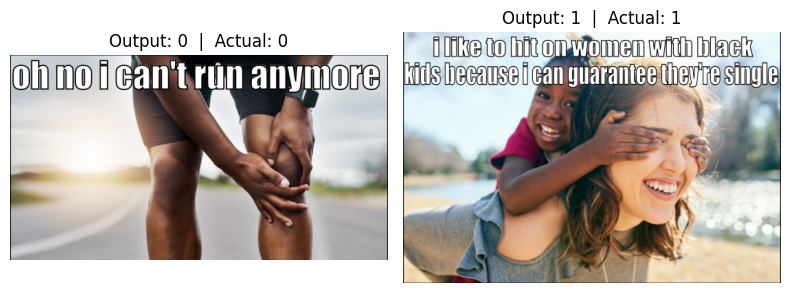

In [ ]:
import matplotlib.pyplot as plt

img_paths   = IMG_DIR

N = len(img_paths)
fig, axes = plt.subplots(1, N, figsize=(4 * N, 4))

if N == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    img = Image.open(img_paths[i])
    ax.imshow(img)

    ax.set_title(f"Output: {output[i][0]}  |  Actual: {actual[i][0]}")

    ax.axis('off')

plt.tight_layout()
plt.show()


# EXPLAINABLE AI MODEL 1

In [ ]:
!pip install captum


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
i_path = IMG_DIR
i_text = IMG_TXT
model_path = '/content/resnet50_bert_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataframe = make_image_text_dataframe(i_path, i_text)

In [ ]:
from captum.attr import IntegratedGradients, visualization as viz
import matplotlib.pyplot as plt

class FeatureExtractor1(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.image_model.fc = nn.Identity()
        self.text_model  = BertModel.from_pretrained('bert-base-uncased')
    def forward(self, img, input_ids, attention_mask):
        img_feat = self.image_model(img)
        txt_feat = self.text_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        return img_feat, txt_feat

class WeightedMultiModalClassifier(nn.Module):
    def __init__(self, img_dim, txt_dim, hidden=256):
        super().__init__()
        self.img_dim = img_dim
        self.txt_dim = txt_dim
        self.img_fc = nn.Sequential(nn.Linear(img_dim, hidden), nn.ReLU())
        self.txt_fc = nn.Sequential(nn.Linear(txt_dim, hidden), nn.ReLU())
        self.classifier = nn.Sequential(nn.Dropout(0.4), nn.Linear(hidden, 2))
    def forward(self, x):
        img_part, txt_part = torch.split(x, [self.img_dim, self.txt_dim], dim=1)
        h_img = self.img_fc(img_part)
        h_txt = self.txt_fc(txt_part)
        return self.classifier(h_img + h_txt)


device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer  = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize
tok = tokenizer(
    i_text,
    return_tensors='pt',
    padding='max_length',
    truncation=True,
    max_length=128
).to(device)

# preprocess and load image
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
img_tensor    = preprocess(Image.open(i_path).convert('RGB')).unsqueeze(0).to(device)

#load model
extractor = FeatureExtractor1().to(device).eval()

with torch.no_grad():
    img_feat, _ = extractor(img_tensor, tok.input_ids, tok.attention_mask)

#get features
with torch.no_grad():
    _, txt_feat = extractor(img_tensor, tok.input_ids, tok.attention_mask)
img_dim, txt_dim = img_feat.size(1), txt_feat.size(1)

classifier = WeightedMultiModalClassifier(img_dim, txt_dim).to(device).eval()
classifier.load_state_dict(torch.load(model_path, map_location=device))

# get predicted class
with torch.no_grad():
    combined = torch.cat([img_feat, txt_feat * 2.0], dim=1)
    pred     = classifier(combined).argmax(-1).item()

# embed the real input
inputs_embed = extractor.text_model.embeddings(tok.input_ids)
# build a PAD-only baseline
baseline_ids = torch.full_like(tok.input_ids, tokenizer.pad_token_id).to(device)
baseline_embed = extractor.text_model.embeddings(baseline_ids)


def forward_with_fixed_image(embeds, attention_mask):
    txt_out   = extractor.text_model(inputs_embeds=embeds,
                                     attention_mask=attention_mask,
                                     return_dict=True)
    txt_pool  = txt_out.pooler_output
    bs        = txt_pool.size(0)

    img_rep   = img_feat.expand(bs, -1)
    combined  = torch.cat([img_rep, txt_pool * 2.0], dim=1)
    return classifier(combined)

#run integrated gradients
ig = IntegratedGradients(forward_with_fixed_image)
txt_attr, delta = ig.attribute(
    inputs=inputs_embed,
    baselines=baseline_embed,
    additional_forward_args=(tok.attention_mask,),
    target=pred,
    return_convergence_delta=True
)
# sum over embedding dim
txt_scores = txt_attr.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens     = tokenizer.convert_ids_to_tokens(tok.input_ids.squeeze(0))

# Prompt 1: Write a function to preprocess and tokenize text and image inputs, extract features using a multi-modal feature extractor, and predict the class.
# Prompt 2: Implement a forward pass with fixed image features, and run Integrated Gradients to compute text token importance scores based on model predictions.


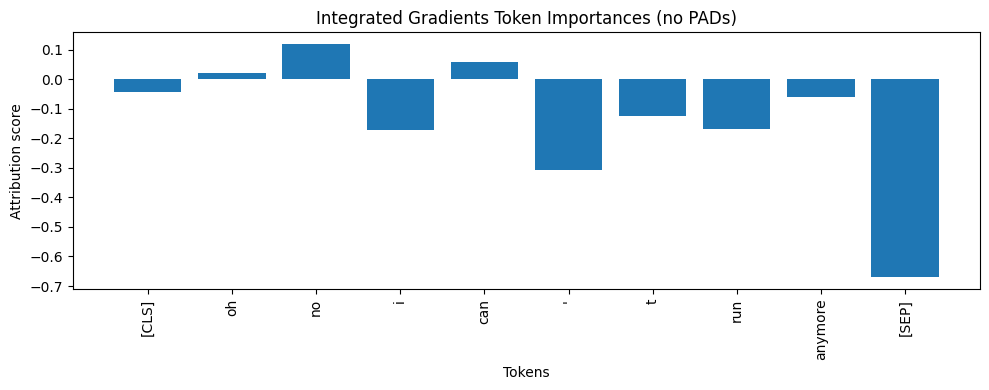

In [ ]:
pad_tok = tokenizer.pad_token

# find all non-pad positions
nonpad_idxs = [i for i, t in enumerate(tokens) if t != pad_tok]

# select only those tokens & scores
filtered_tokens = [tokens[i] for i in nonpad_idxs]
filtered_scores = txt_scores[nonpad_idxs]


plt.figure(figsize=(10, 4))
plt.bar(range(len(filtered_tokens)), filtered_scores)
plt.xticks(range(len(filtered_tokens)), filtered_tokens, rotation=90)
plt.xlabel("Tokens")
plt.ylabel("Attribution score")
plt.title("Integrated Gradients Token Importance")
plt.tight_layout()
plt.show()




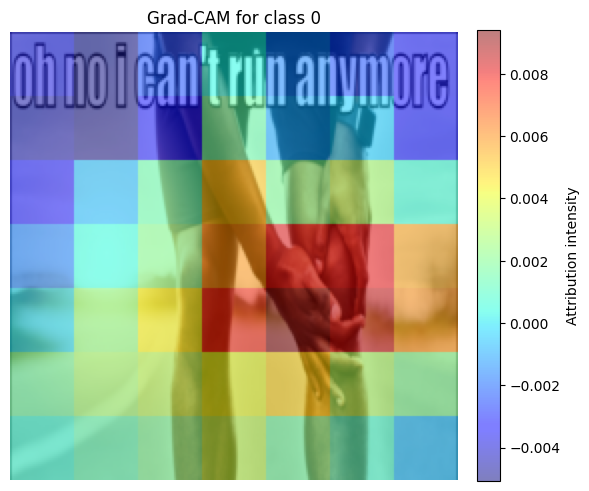

In [ ]:
from captum.attr import LayerGradCam
from torchvision.models import resnet50, ResNet50_Weights


def image_only_forward(img):
    with torch.no_grad():
        _, txt_feat = extractor(
            img_tensor,
            tok.input_ids,
            tok.attention_mask
        )

    bs = img.size(0)
    txt_rep = txt_feat.expand(bs, -1) * 2.0

    img_feat = extractor.image_model(img)
    combined = torch.cat([img_feat, txt_rep], dim=1)
    return classifier(combined)

#pick the last conv layer
target_layer = extractor.image_model.layer4[-1].conv2

#run Grad-CAM
gc = LayerGradCam(image_only_forward, target_layer)
attr = gc.attribute(
    img_tensor,
    target=pred
)

# after upsampling:
attr_up = LayerGradCam.interpolate(attr, img_tensor.shape[2:])[0]


# denormalize the image for plotting
np_img = img_tensor[0].cpu().numpy().transpose(1,2,0)
mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])
np_img = np.clip(std * np_img + mean, 0, 1)


# drop the channel dim
cam_map = attr_up.squeeze(0).cpu().detach().numpy()

# overlay
fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(np_img)
# overlay the CAM, keep the returned artist
cam_artist = ax.imshow(cam_map, cmap='jet', alpha=0.5)

# Remove axes ticks
ax.axis('off')
ax.set_title(f'Grad-CAM for class {pred}')

fig.colorbar(cam_artist, ax=ax, fraction=0.046, pad=0.04, label='Attribution intensity')

plt.tight_layout()
plt.show()

# Prompt 1: Implement a function for Grad-CAM visualization by defining a forward pass that combines image features and tokenized text features.
# Use a selected convolutional layer for Grad-CAM attribution.
# Prompt 2: Run Grad-CAM, interpolate the attribution map, denormalize the image, and overlay the heatmap on the image, displaying the result with a color bar.



# EXPLAINABLE AI MODEL 2

Loaded pretrained weights for efficientnet-b0


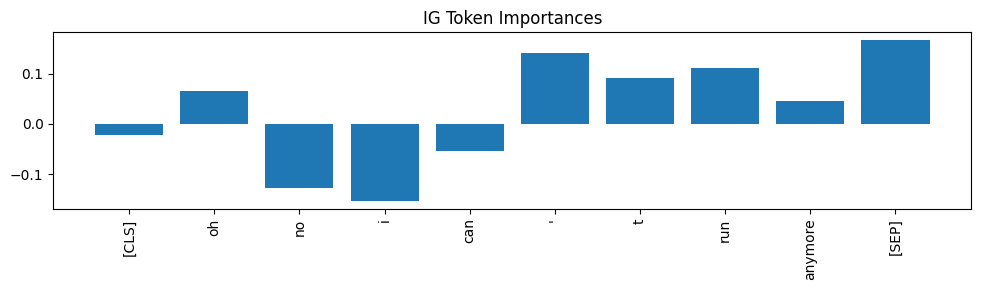

In [ ]:
from captum.attr import IntegratedGradients, LayerGradCam
from efficientnet_pytorch import EfficientNet

class MultiModalExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_model = EfficientNet.from_pretrained('efficientnet-b0')
        self.text_model  = DistilBertModel.from_pretrained('distilbert-base-uncased')

    def forward(self, images, input_ids, attention_mask):
        feat = self.image_model.extract_features(images)
        feat = nn.functional.adaptive_avg_pool2d(feat, (1,1)).squeeze(-1).squeeze(-1)

        txt = self.text_model(input_ids=input_ids, attention_mask=attention_mask)\
                  .last_hidden_state[:,0,:]
        return feat, txt

class MultiModalClassifier(nn.Module):
    def __init__(self, image_dim=1280, text_dim=768):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(image_dim + text_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
    def forward(self, img_feat, txt_feat):
        return self.classifier(torch.cat([img_feat, txt_feat], dim=1))


device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer    = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_path   = '/content/resnet18_disbert_model.pth'

# initialize and load
extractor2   = MultiModalExtractor().to(device).eval()
classifier   = MultiModalClassifier().to(device).eval()
classifier.load_state_dict(torch.load(model_path, map_location=device))


pre = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
img_tensor = pre(Image.open(i_path).convert('RGB')).unsqueeze(0).to(device)
# text
tok = tokenizer(i_text, return_tensors='pt',
                padding='max_length', truncation=True, max_length=128)
tok = {k:v.to(device) for k,v in tok.items()}


with torch.no_grad():
    img_feat, txt_feat = extractor2(img_tensor, tok['input_ids'], tok['attention_mask'])
    # apply weights
    img_feat = img_feat * 0.1
    txt_feat = txt_feat * 1.5
    logits   = classifier(img_feat, txt_feat)
    pred     = logits.argmax(-1).item()

# get embeddings & PAD baseline
embeds       = extractor2.text_model.embeddings(tok['input_ids'])  # [1,128,768]
pad_ids      = torch.full_like(tok['input_ids'], tokenizer.pad_token_id)
base_embeds  = extractor2.text_model.embeddings(pad_ids)

def forward_text(emb, attn_mask):
    txt_out = extractor2.text_model(inputs_embeds=emb, attention_mask=attn_mask)
    txt_cls = txt_out.last_hidden_state[:,0,:]

    img_rep = (img_feat * 0.1).expand(txt_cls.size(0), -1)
    txt_rep = txt_cls * 2.0
    return classifier(img_rep, txt_rep)

ig = IntegratedGradients(forward_text)
attr_txt, delta = ig.attribute(
    inputs=embeds,
    baselines=base_embeds,
    additional_forward_args=(tok['attention_mask'],),
    target=pred,
    return_convergence_delta=True
)


scores = attr_txt.sum(dim=-1).squeeze(0).detach().cpu().numpy()
tokens = tokenizer.convert_ids_to_tokens(tok['input_ids'].squeeze(0))
# drop PADs
idxs = [i for i,t in enumerate(tokens) if t != tokenizer.pad_token]
tokens = [tokens[i] for i in idxs]
scores = scores[idxs]

# plot
plt.figure(figsize=(10,3))
plt.bar(range(len(tokens)), scores)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title("IG Token Importances")
plt.tight_layout()
plt.show()


# Prompt: Implement a function for Integrated Gradients attribution to analyze the importance of text tokens
# using a fixed image representation and compute the attribution scores.

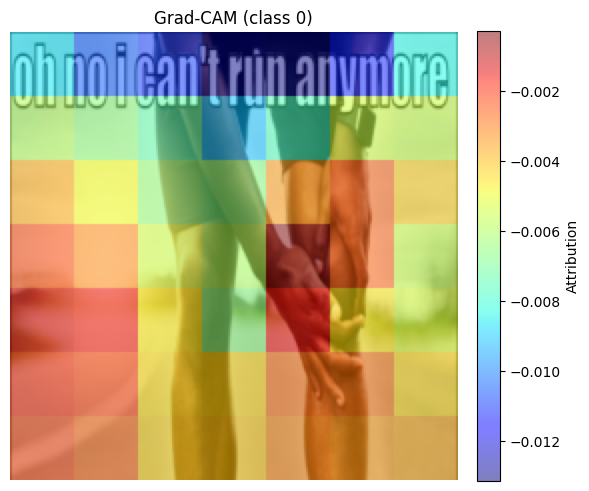

In [ ]:
with torch.no_grad():
    txt0 = extractor2.text_model( input_ids=tok['input_ids'],
                                  attention_mask=tok['attention_mask']
                                ).last_hidden_state[:,0,:] * 1.5

def forward_image(x):
    img_f = extractor2.image_model.extract_features(x)
    img_f = nn.functional.adaptive_avg_pool2d(img_f, (1,1)).squeeze(-1).squeeze(-1)
    img_f = img_f * 0.1
    # expand text
    txt_rep = txt0.expand(img_f.size(0), -1)
    return classifier(img_f, txt_rep)

# pick last conv layer of EfficientNet
target_layer = extractor2.image_model._conv_head

gc = LayerGradCam(forward_image, target_layer)
attr_img = gc.attribute(img_tensor, target=pred)
attr_up  = LayerGradCam.interpolate(attr_img, img_tensor.shape[2:])\
                .squeeze(0).squeeze(0).cpu().detach().numpy()

# denormalize and plot with colorbar
img_np = img_tensor[0].cpu().numpy().transpose(1,2,0)
mean, std = np.array([0.485,0.456,0.406]), np.array([0.229,0.224,0.225])
img_np = np.clip(std*img_np + mean, 0,1)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_np)
hm = ax.imshow(attr_up, cmap='jet', alpha=0.5)
ax.set_axis_off()
ax.set_title(f'Grad-CAM (class {pred})')
fig.colorbar(hm, ax=ax, fraction=0.046, pad=0.04, label='Attribution')
plt.tight_layout()
plt.show()

# Prompt 1: Extract features from text and image inputs, and implement a forward pass for Grad-CAM visualization using a fixed text representation and image features.
# Prompt 2: Apply Grad-CAM to the last convolutional layer of EfficientNet, interpolate the attribution map, denormalize the image, and overlay the heatmap on the image with a color bar.



# EXPLAINABLE AI MODEL 3

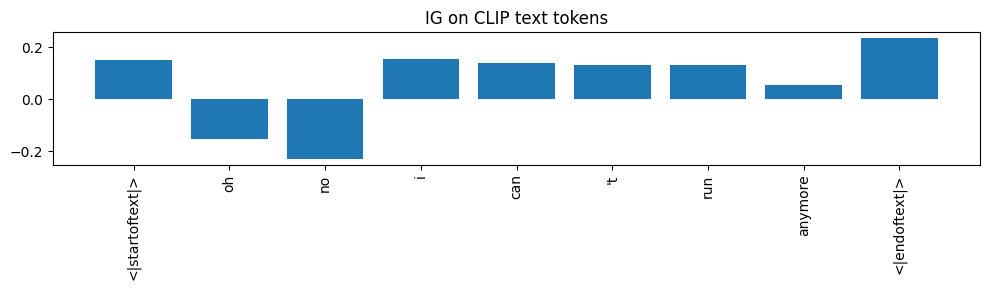

In [ ]:
import clip
from captum.attr import LayerIntegratedGradients, Saliency
from clip.simple_tokenizer import SimpleTokenizer

device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model, preprocess = clip.load("ViT-B/32", device=device)

class EmbeddingClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.5, num_classes=2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.fc(x)

model_path = "/content/best_classifier.pth"
classifier = EmbeddingClassifier(512*2, hidden_dim=512, dropout=0.5, num_classes=2)
classifier.load_state_dict(torch.load(model_path, map_location=device))
classifier.to(device).eval()


row    = dataframe.iloc[0]
i_path = row["img"]
txt    = row["text"][:300]

img_tensor = preprocess(Image.open(i_path).convert("RGB")) \
                 .unsqueeze(0).to(device)
# prepare text tokens
tokens = clip.tokenize([txt]).to(device)


with torch.no_grad():
    img_f = clip_model.encode_image(img_tensor).float()
    img_f = img_f / (img_f.norm(dim=-1, keepdim=True) + 1e-6)
    img_f_w = img_f * 0.5

    txt_f = clip_model.encode_text(tokens).float()
    txt_f = txt_f / (txt_f.norm(dim=-1, keepdim=True) + 1e-6)
    txt_f_w = txt_f * 1.5

    logits = classifier(torch.cat([img_f_w, txt_f_w], dim=1))
    pred   = logits.argmax(-1).item()


def forward_text(tok_ids):
    t = clip_model.encode_text(tok_ids).float()
    t = t / (t.norm(dim=-1, keepdim=True) + 1e-6)
    t = t * 1.5
    # expand image
    im = img_f_w.expand(t.size(0), -1)
    feats = torch.cat([im, t], dim=1)
    return classifier(feats)

lig = LayerIntegratedGradients(forward_text, clip_model.token_embedding)


baseline_tokens = torch.zeros_like(tokens).to(device)

attr_tok, delta = lig.attribute(
    inputs=tokens,
    baselines=baseline_tokens,
    target=pred,
    return_convergence_delta=True
)

# aggregate over embedding dim
tok_scores = attr_tok.sum(dim=-1).squeeze(0).detach().cpu().numpy()


stoks = tokens.squeeze(0).cpu().numpy().tolist()
simple_tok = SimpleTokenizer()
tok_strs = [simple_tok.decode([t]).strip() for t in stoks]


valid = [i for i,t in enumerate(stoks) if t != 0]
tok_strs   = [tok_strs[i] for i in valid]
tok_scores = tok_scores[valid]

# plot
plt.figure(figsize=(10,3))
plt.bar(range(len(tok_strs)), tok_scores)
plt.xticks(range(len(tok_strs)), tok_strs, rotation=90)
plt.title("IG on CLIP text tokens")
plt.tight_layout()
plt.show()

# Prompt 1: Load and preprocess image and text inputs, use CLIP for encoding, and make predictions with a classifier that combines image and text embeddings.
# Prompt 2: Implement Integrated Gradients for attribution of text tokens, aggregate the attribution scores, and visualize the results in a bar chart.




/usr/local/lib/python3.11/dist-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


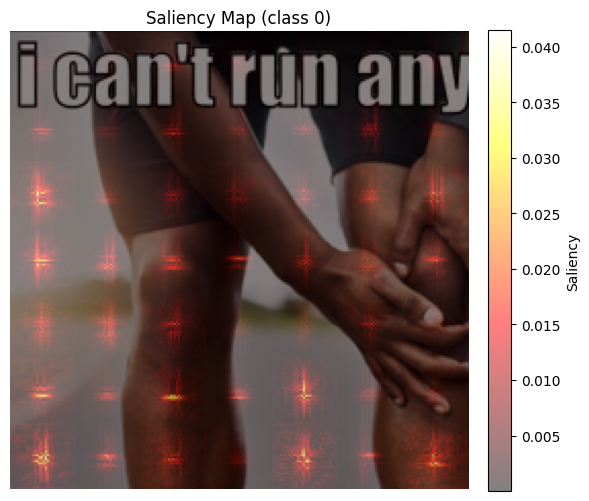

In [ ]:
def forward_image(x):
    im = clip_model.encode_image(x).float()
    im = im / (im.norm(dim=-1, keepdim=True) + 1e-6)
    im = im * 0.5
    # expand text
    t = txt_f_w.expand(im.size(0), -1)
    feats = torch.cat([im, t], dim=1)
    return classifier(feats)

sal = Saliency(forward_image)
attr_img = sal.attribute(img_tensor, target=pred)

# aggregate across channels
sal_map = attr_img.abs().max(dim=1)[0].squeeze(0).detach().cpu().numpy()

# denormalize image for display
np_img = img_tensor[0].cpu().numpy().transpose(1,2,0)
mean, std = np.array([0.48145466,0.4578275,0.40821073]), np.array([0.26862954,0.26130258,0.27577711])
np_img = np.clip(std*np_img + mean, 0, 1)

# overlay + colorbar
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np_img)
hm = ax.imshow(sal_map, cmap='hot', alpha=0.5)
ax.axis('off')
ax.set_title(f"Saliency Map (class {pred})")
fig.colorbar(hm, ax=ax, fraction=0.046, pad=0.04, label="Saliency")
plt.tight_layout()
plt.show()

#Prompt: Implement a forward pass for image features by combining image embeddings and text features, and make predictions using a classifier.